In [14]:
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class NeuralNet:
    def __init__(self, layers, epochs, learning_rate, momentum, activation_function, validation_split):
        self.L = len(layers)
        self.n = layers.copy()
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.fact = activation_function
        self.validation_split = validation_split

        # Initialize arrays for network components
        self.train_errors = []
        self.val_errors = []
        self.h = [np.zeros(n) for n in layers]
        self.xi = [np.zeros(n) for n in layers]
        self.w = [np.zeros((1, 1))] + [np.random.uniform(-1.0, 1.0, (layers[i], layers[i-1])) * np.sqrt(1 / layers[i-1]) for i in range(1, self.L)]
        self.theta = [np.zeros(n) for n in layers]
        self.delta = [np.zeros(n) for n in layers]
        self.d_w = [np.zeros_like(self.w[i]) for i in range(self.L)]
        self.d_theta = [np.zeros_like(self.theta[i]) for i in range(self.L)]
        self.d_w_prev = [np.zeros_like(self.w[i]) for i in range(self.L)]
        self.d_theta_prev = [np.zeros_like(self.theta[i]) for i in range(self.L)]

    def fit(self, X, y):
        n_samples, n_features = X.shape
        # Split data into training and validation sets (80% training, 20% validation)
        split_index = int(n_samples * 0.8)
        X_train, X_val = X[:split_index], X[split_index:]
        y_train, y_val = y[:split_index], y[split_index:]

        for epoch in range(self.epochs):
            for pat in range(len(X_train)):
                # Choose a random pattern from the training set
                idx = np.random.randint(0, len(X_train))
                x_mu, z_mu = X_train[idx], y_train[idx]

                # Forward propagation
                self._forward_propagate(x_mu)

                # Backpropagation
                self._back_propagate(z_mu)

                # Update weights and thresholds
                self._update_weights()

            # Calculate training and validation error
            train_error = self._calculate_error(X_train, y_train)
            val_error = self._calculate_error(X_val, y_val)
            self.train_errors.append(train_error)
            self.val_errors.append(val_error)
            print(f"Epoch {epoch+1}/{self.epochs}, Training Error: {train_error}, Validation Error: {val_error}")

    def predict(self, X):
        n_samples, n_features = X.shape
        y_pred = np.zeros(n_samples)
        for i in range(n_samples):
            self._forward_propagate(X[i])
            y_pred[i] = self.xi[-1]  # Output layer activation
        return y_pred

    def loss_epochs(self):
        training_error = np.zeros(self.epochs)
        validation_error = np.zeros(self.epochs)
        # Track and return training and validation error evolution per epoch
        return training_error, validation_error

    def _forward_propagate(self, x):
        # Set input layer activations
        self.xi[0] = np.array(x, dtype=float)  # Ensure x is a NumPy array
        # Propagate through layers
        for l in range(1, self.L):
            self.h[l] = np.dot(self.w[l], self.xi[l-1]) - self.theta[l]
            self.xi[l] = self._activation(self.h[l])

    def _back_propagate(self, z):
        # Compute output layer error
        self.delta[-1] = (self.xi[-1] - z) * self._activation_derivative(self.h[-1])
        # Propagate error backwards through hidden layers
        for l in range(self.L-2, 0, -1):
            self.delta[l] = np.dot(self.w[l+1].T, self.delta[l+1]) * self._activation_derivative(self.h[l])

    def _update_weights(self):
        # Update weights and thresholds using gradient descent with momentum
        for l in range(1, self.L):
            self.d_w[l] = -self.learning_rate * np.outer(self.delta[l], self.xi[l-1]) + self.momentum * self.d_w_prev[l]
            self.d_theta[l] = -self.learning_rate * self.delta[l] + self.momentum * self.d_theta_prev[l]
            self.w[l] += self.d_w[l]
            self.theta[l] += self.d_theta[l]
            self.d_w_prev[l] = self.d_w[l]
            self.d_theta_prev[l] = self.d_theta[l]

    def _activation(self, x):
        if self.fact == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(x, -500, 500)))  # Clip values to prevent overflow
        elif self.fact == 'relu':
            return np.maximum(0, x)
        elif self.fact == 'linear':
            return x
        elif self.fact == 'tanh':
            return np.tanh(np.clip(x, -500, 500))  # Clip values to prevent overflow
        else:
            raise ValueError("Unsupported activation function")

    def _activation_derivative(self, x):
        if self.fact == 'sigmoid':
            sig = 1 / (1 + np.exp(-np.clip(x, -500, 500)))
            return sig * (1 - sig)
        elif self.fact == 'relu':
            return np.where(x > 0, 1, 0)
        elif self.fact == 'linear':
            return np.ones_like(x)
        elif self.fact == 'tanh':
            return 1 - np.tanh(np.clip(x, -500, 500)) ** 2
        else:
            raise ValueError("Unsupported activation function")

    def _calculate_error(self, X, y):
        total_error = 0
        for i in range(len(X)):
            self._forward_propagate(X[i])
            total_error += 0.5 * np.sum((self.xi[-1] - y[i]) ** 2)
        return total_error / len(X)

def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, mae, mape

# Load training data from CSV file
train_data = pd.read_csv('train_data.csv')

# Convert categorical features to dummy variables
train_data = pd.get_dummies(train_data)

# Separate features and target variable
X = train_data.drop(columns=['CO2 Emissions(g/km)']).values  #'CO2 Emissions(g/km)' is the target variable
y = train_data['CO2 Emissions(g/km)'].values


layers = [X.shape[1], 9, 5, 1]  # Network architecture: input layer size based on data, 9 and 5 hidden, 1 output
learning_rate = 0.05
momentum = 0.95
activation_function = 'sigmoid'
epochs = 15

# Initialize and train the model
neural_net = NeuralNet(layers, epochs=epochs, learning_rate=learning_rate, momentum=momentum, activation_function=activation_function, validation_split=0.2)
neural_net.fit(X, y)

# Save evaluation metrics
train_error = neural_net._calculate_error(X, y)
mse, mae, mape = evaluate(y, neural_net.predict(X))
hyperparameter_results = []
hyperparameter_results.append({
    'Number of layers': len(layers),
    'Layer Structure': layers,
    'Num epochs': epochs,
    'Learning Rate': learning_rate,
    'Momentum': momentum,
    'Activation function': activation_function,
    'Training Error': train_error,
    'MSE': mse,
    'MAE': mae,
    'MAPE': mape
})

# Convert results to DataFrame
results_df = pd.DataFrame(hyperparameter_results)
print(results_df)

# Save the trained model
with open('neural_net_model.pkl', 'wb') as file:
    pickle.dump(neural_net, file)
print("Model saved successfully.")

print("L =", neural_net.L)
print("n =", neural_net.n)
print("Weights for layer 2:", neural_net.w[2])


Epoch 1/15, Training Error: 0.0020611449639833367, Validation Error: 0.0021989986986038377
Epoch 2/15, Training Error: 0.0002742245854535168, Validation Error: 0.000353096030148437
Epoch 3/15, Training Error: 0.0001684003229363162, Validation Error: 0.0002244025232584219
Epoch 4/15, Training Error: 0.00011084387380957927, Validation Error: 0.0001640103443149679
Epoch 5/15, Training Error: 9.530373884180565e-05, Validation Error: 0.0001553092808790658
Epoch 6/15, Training Error: 8.107347634672616e-05, Validation Error: 0.00013765574476987938
Epoch 7/15, Training Error: 9.593179628619329e-05, Validation Error: 0.0001577999651473352
Epoch 8/15, Training Error: 6.977653693396015e-05, Validation Error: 0.00012998661175278305
Epoch 9/15, Training Error: 6.684133074613635e-05, Validation Error: 0.0001311022553081111
Epoch 10/15, Training Error: 6.497649826478057e-05, Validation Error: 0.0001267579904874469
Epoch 11/15, Training Error: 6.271850904082423e-05, Validation Error: 0.000124412244717

<ipython-input-14-7b2313fec2dc>:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = self.xi[-1]  # Output layer activation


   Number of layers  Layer Structure  Num epochs  Learning Rate  Momentum  \
0                 4  [2016, 9, 5, 1]          15           0.05      0.95   

  Activation function  Training Error       MSE       MAE  MAPE  
0             sigmoid        0.000189  0.000377  0.012769   inf  
Model saved successfully.
L = 4
n = [2016, 9, 5, 1]
Weights for layer 2: [[ 2.91788966e-01 -4.12665978e-01 -3.58775476e-02  7.32417084e-01
   3.50476064e-01 -1.36392412e-01 -2.10971305e-01  2.16976819e-01
   7.62580774e-04]
 [ 4.81154790e-02 -8.53846961e-04 -1.65582257e-01 -2.39359986e-01
  -2.29065739e-01  1.14033171e-01  7.70733078e-02 -3.40568342e-01
  -7.79962463e-03]
 [ 2.24762846e+00  4.37988271e-01  1.42456521e-01  2.23320513e+00
   2.17711692e+00  3.83676236e-01  5.21281716e-01  2.00498670e+00
   1.63933294e+00]
 [-1.71821075e+00 -2.98598231e-01 -2.17594809e-01 -1.98341655e+00
  -2.09284057e+00 -5.35449452e-01 -7.09938165e-01 -2.32343319e+00
  -1.26624378e+00]
 [-6.16516220e-01  2.31678069e-01 -2

<ipython-input-14-7b2313fec2dc>:134: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Model loaded successfully.


<ipython-input-14-7b2313fec2dc>:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = self.xi[-1]  # Output layer activation


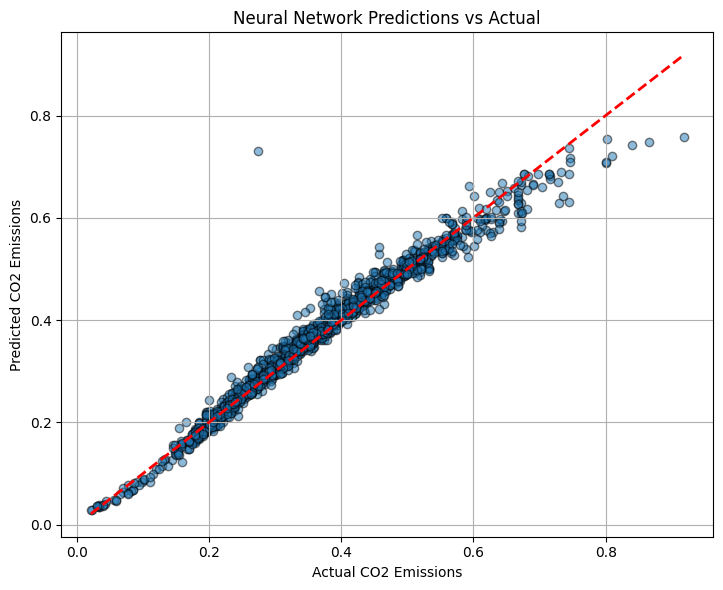

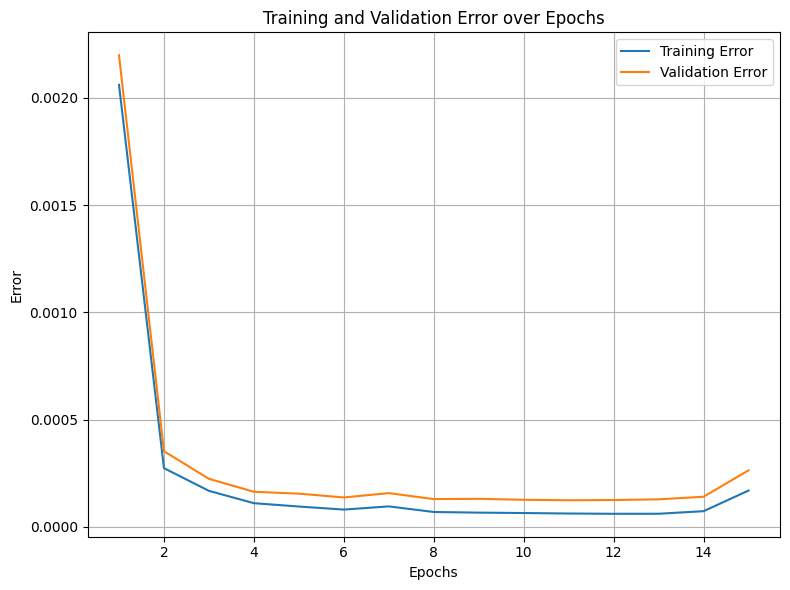

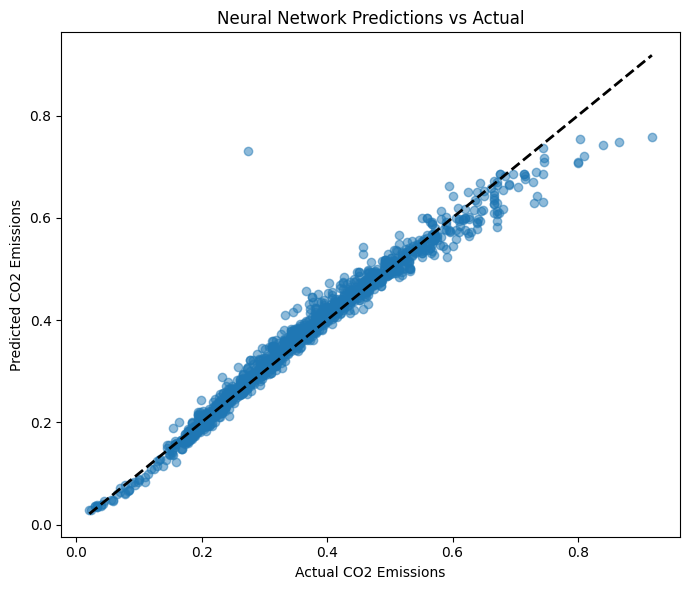

Neural Network - MSE: 0.0005706537496065082, MAE: 0.014511056892606107, MAPE: 4.32934745368195


In [16]:
# Cell 1: Neural Network class and data preprocessing
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Store columns of training data to apply to test data
train_columns = train_data.columns
test_data = pd.read_csv('test_data.csv')

# Convert categorical features to dummy variables
test_data = pd.get_dummies(test_data)

# Align test data with training data columns to ensure matching feature set
test_data = test_data.reindex(columns=train_columns, fill_value=0)

# Separate features and target variable for test data
X_test = test_data.drop(columns=['CO2 Emissions(g/km)']).values  # Assuming 'CO2 Emissions(g/km)' is the target variable
y_test = test_data['CO2 Emissions(g/km)'].values

# Check if model exists
try:
    with open('neural_net_model.pkl', 'rb') as file:
        neural_net = pickle.load(file)
    print("Model loaded successfully.")
except FileNotFoundError:
    print("Training the model...")
    neural_net.fit(X, y)
    with open('neural_net_model.pkl', 'wb') as file:
        pickle.dump(neural_net, file)
    print("Model saved successfully.")

# Make predictions with neural network
nn_predictions = neural_net.predict(X_test)

# Evaluation metrics
# Generate scatter plots for representative rows
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, nn_predictions, alpha=0.5, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual CO2 Emissions')
plt.ylabel('Predicted CO2 Emissions')
plt.title('Neural Network Predictions vs Actual')
plt.grid(True)
plt.tight_layout()
plt.show()

# Generate error evolution plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(neural_net.train_errors) + 1), neural_net.train_errors, label='Training Error')
plt.plot(range(1, len(neural_net.val_errors) + 1), neural_net.val_errors, label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Training and Validation Error over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, mae, mape

# Scatter plot
plt.figure(figsize=(7, 6))
plt.scatter(y_test, nn_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual CO2 Emissions')
plt.ylabel('Predicted CO2 Emissions')
plt.title('Neural Network Predictions vs Actual')
plt.tight_layout()
plt.show()

nn_mse, nn_mae, nn_mape = evaluate(y_test, nn_predictions)

print(f"Neural Network - MSE: {nn_mse}, MAE: {nn_mae}, MAPE: {nn_mape}")
